<a href="https://colab.research.google.com/github/Michael-Jimenez-C/Investigaci-n-de-operaciones/blob/main/pert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.DataFrame({"Actividad":"1 2 3 4 5 6 7 8 9 10 11 12 13 14 15".split(" "),
                 "Tiempo":[40,30,30,40,40,60,40,50,30,50,5,30,30,30,10],
                 "dependencia":["0","0","0","0","0","0","0","0","0","0","0","2,3,4,5,6,7","8,9","10","1,11,12,13,14"],
                 "recurso":[10,10,10,10,10,10,4,7,10,2,7,1,12,4,5]})

In [3]:
class Nodo:
  def __init__(self,contenido):
    self.contenido=contenido
    self.padres=[]
    self.next=[]
  def agregar(self,nodo):
    if nodo not in self.next:
      nodo.padres.append(self)
      self.next.append(nodo)
  def __repr__(self):
    return str(self.contenido) if self.contenido!=None else ""

In [58]:
class Proyecto:
  def __init__(self,actividades,tiempos,dependencias):
    nodos=[Nodo({"actividad":"0",
         "t":0,
         "dep":None})]
    for i in range(len(actividades)):
      k={"actividad":actividades[i],
         "t":tiempos[i],
         "dep":dependencias[i].split(",")}
      nodos.append(Nodo(k))
    
    for i in nodos:
      for j in nodos:
        if i.contenido["dep"]!=None:
          if j.contenido["actividad"] in i.contenido["dep"]:
            j.agregar(i)
    self.nodos=nodos
  def rutaCritica(self) :
    for i,k in enumerate(self.nodos):
      k.contenido["tmax"]=np.inf
      k.contenido["tmin"]=0
      k.contenido["t0"]=0
      max=0

    for i in self.nodos:
      for j in i.next:
        j.contenido["tmin"]=np.maximum(j.contenido["tmin"],i.contenido["tmin"]+j.contenido["t"])
        j.contenido["t0"]=np.maximum(j.contenido["t0"],i.contenido["t0"]+i.contenido["t"])

        if len(j.next)==len([]):
          j.contenido["tmax"]=j.contenido["tmin"]
          j.contenido["TRT"]=j.contenido["tmax"]-j.contenido["tmin"]

          if max<j.contenido["tmax"]:
            max=j.contenido["tmax"]

            
    for i in reversed(self.nodos):
      for j in i.padres:
        j.contenido["tmax"]=np.minimum(j.contenido["tmax"],i.contenido["tmax"]-i.contenido["t"])
        j.contenido["TRT"]=j.contenido["tmax"]-j.contenido["tmin"]
    self.max=max

  def __gantc__(self,x):
    u=lambda x,l,s:np.piecewise(x, [x<l,(x>=l)*(x<=s),x>s],[lambda x: 0*x, lambda x: 1+0*x, lambda x: 0*x])
    f=[]
    for i in self.nodos:
      x_l=i.contenido["t0"]
      x_s=x_l+i.contenido["t"]
      f.append(u(x,x_l,x_s))
    return f
  def gant(self):
    x=np.linspace(0,self.max,self.max*2)
    f=self.__gantc__(x)

    for i in enumerate(f):
      plt.plot(x,i[1]*i[0],label=r"Actividad "+r"$"+str(i[0])+r"$")
    plt.yticks([i for i in range(0,len(f))])
    plt.ylabel("ACTIVIDAD")
    plt.xlabel("TIEMPO")
    plt.title("DIAGRAMA DE GANT")
    plt.grid()
    plt.xlim(0)
    plt.tight_layout()
    return plt
  
  def __calcularSumaRecursos(self,x,asignacion_recurso):
    x=np.linspace(0,self.max,self.max*2)
    rec=[0]
    rec.extend(asignacion_recurso)
    f=self.__gantc__(x)
    y=sum([f[i]*rec[i] for i in range(len(f))])

    return y

  def digrama_recurso_vs_tiempo(self,asignacion_recurso,recurso_ref):
    x=np.linspace(0,self.max,self.max*2)
    y=self.__calcularSumaRecursos(x,asignacion_recurso)
    Yc=np.piecewise(y,[y>=recurso_ref,y<recurso_ref],[lambda y:y, lambda y:0*y+recurso_ref])

    plt.plot(x,y)
    plt.plot(x,0*x+recurso_ref)
    plt.fill_between(x,Yc,0*y+recurso_ref,color="red",alpha=.5)
    plt.xlabel("TIEMPO")
    plt.ylabel("RECURSO")   
    plt.title("RECURSO VS TIEMPO") 
    plt.grid()
    plt.xlim(0)
    plt.tight_layout()
    return plt
  def gantResumen(self,asignacion_recurso,recurso_ref):
    plt.figure(figsize=(6,8))
    plt.subplot(2,1,1)
    s.gant()
    plt.title("")
    plt.xlabel("")
    plt.xticks([i for i in range(0,self.max+1,20)],[])
    plt.subplot(2,1,2)
    s.digrama_recurso_vs_tiempo(asignacion_recurso,recurso_ref)
    plt.title("")
    plt.xticks([i for i in range(0,self.max+1,20)])
    plt.show()


  def gray_kidd(self,asignacion_recurso,recurso_ref):
    x=np.linspace(0,self.max,self.max*2)
    y=self.__calcularSumaRecursos(x,asignacion_recurso)
    if (y<=recurso_ref).all()==True:
      return None
    #intervalos
    intervalos=[0]
    for i in self.nodos:
      x_s=i.contenido["t0"]
      x_f=x_s+i.contenido["t"]
      if x_s not in intervalos:
        intervalos.append(x_s)
      if x_f not in intervalos:
        intervalos.append(x_f)
    intervalos=np.sort(intervalos)
    #analisis:
    desp=0
    nodos=[]
    for i in range(len(intervalos)-1):
      if (y[(x>intervalos[i])*(x<intervalos[i+1])]>recurso_ref).any()==True:
        print(intervalos[i],intervalos[i+1])
        nodos=[]
        rec=[]
        for k,j in enumerate(self.nodos):
          if j.contenido["t0"]<=intervalos[i] and (j.contenido["t0"]+j.contenido["t"])>=intervalos[i+1] and j.contenido["actividad"]!="0":
            nodos.append(j)
            rec.append(asignacion_recurso[k-1])
        desp=intervalos[i+1]-intervalos[i]
        break

    for i in range(len(nodos)):
      for j in range(i,len(nodos)):
        if nodos[i].contenido["TRT"]>nodos[j].contenido["TRT"]:
          temp=nodos[i]
          nodos[i]=nodos[j]
          nodos[j]=temp
        elif nodos[i].contenido["TRT"]==nodos[j].contenido["TRT"] and rec[i]<rec[j]:
          temp=nodos[i]
          nodos[i]=nodos[j]
          nodos[j]=temp

          temp2=rec[i]
          rec[i]=rec[j]
          rec[j]=temp2
    print([i.contenido["TRT"] for i in nodos])
    print(rec)
    suma=0
    for i in range(len(nodos)):
      if suma+rec[0]>recurso_ref or suma==recurso_ref:
        break
      suma+=rec[0]
      rec.pop(0)
      nodos.pop(0)
      
    for i in range(len(nodos)):
      nodos[i].contenido["t0"]+=desp
      
    self.gantResumen(asignacion_recurso,recurso_ref)
    plt.show()

    self.gray_kidd(asignacion_recurso,recurso_ref)
    

In [56]:
s=Proyecto(df["Actividad"],df["Tiempo"],df["dependencia"])
s.rutaCritica()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

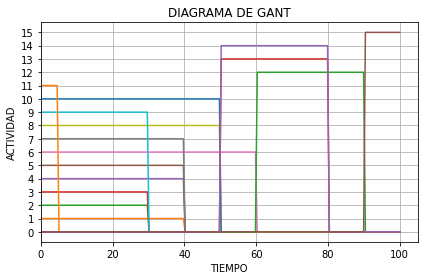

In [6]:
s.gant()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

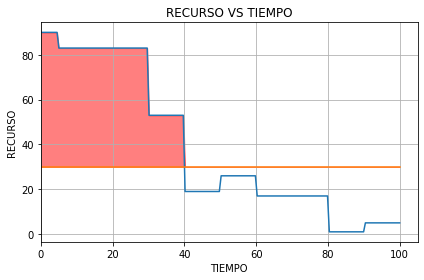

In [10]:
s.digrama_recurso_vs_tiempo(df["recurso"],30)

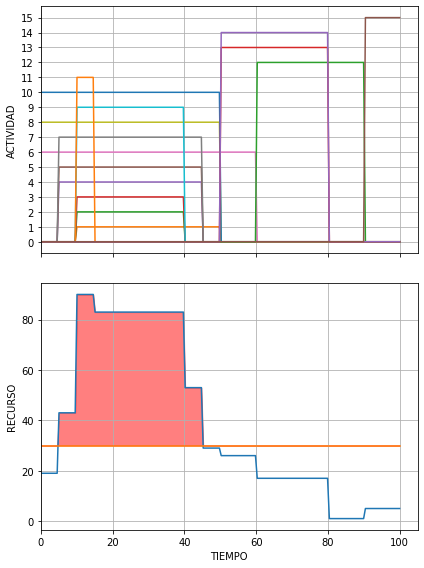

In [32]:
s.gantResumen(df["recurso"],30)

0 5
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


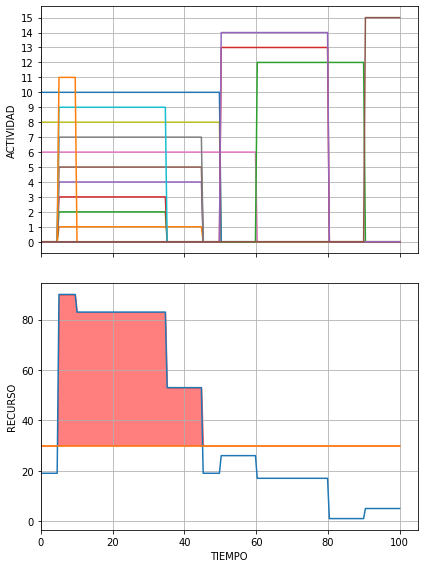

5 10
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


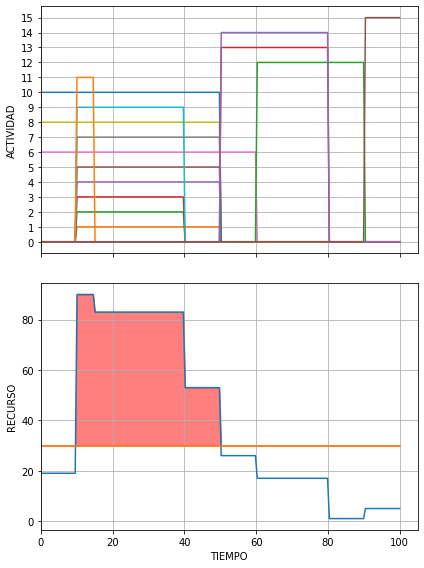

10 15
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


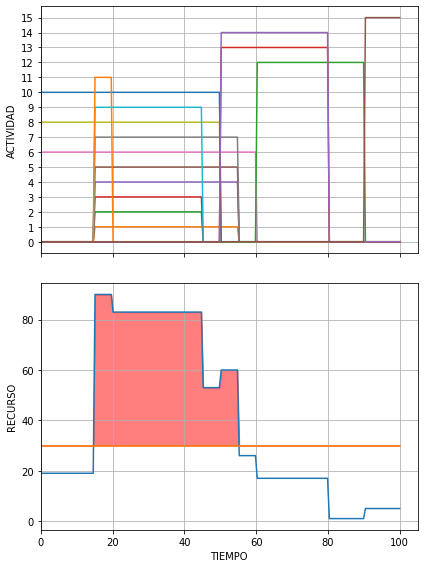

15 20
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


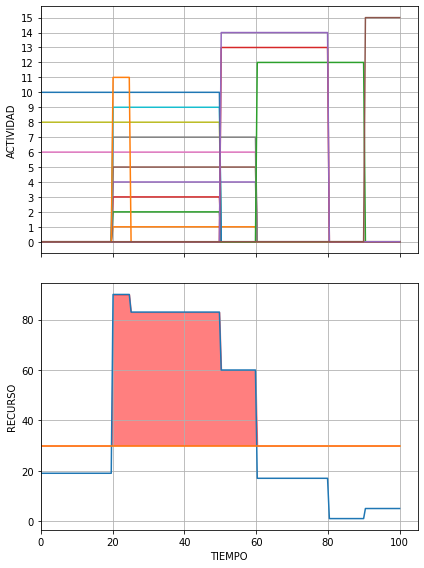

20 25
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


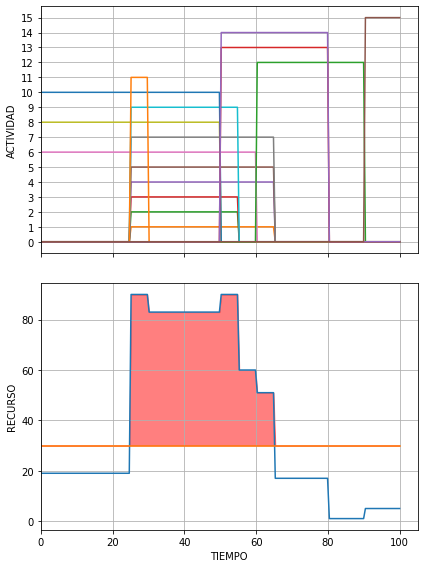

25 30
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


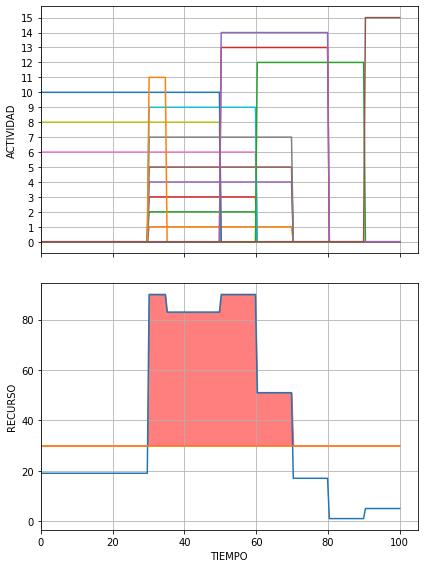

30 35
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


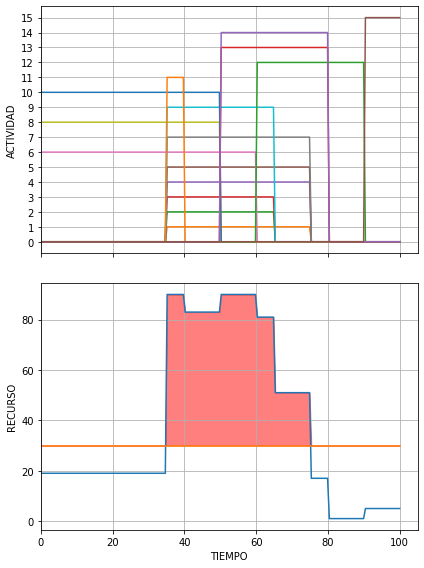

35 40
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


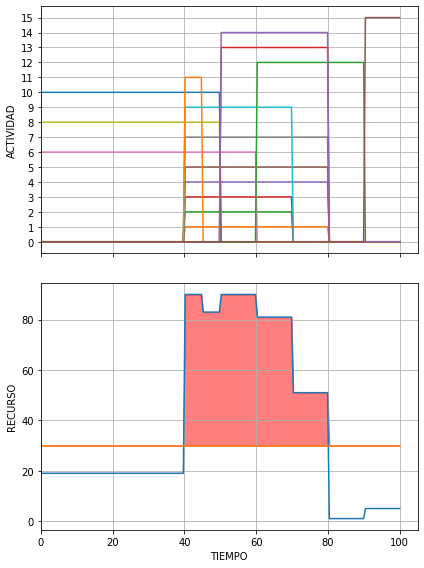

40 45
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


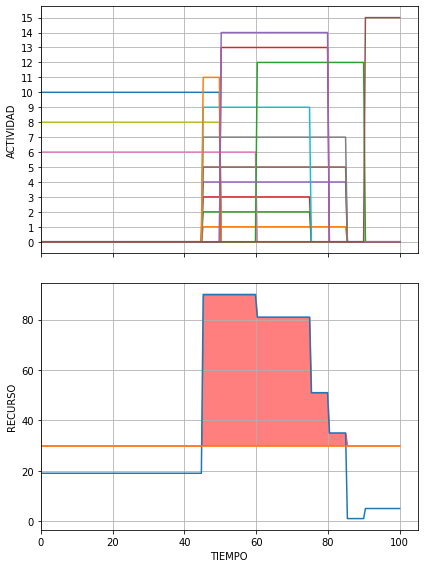

45 50
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 10, 10, 7, 4, 2, 7]


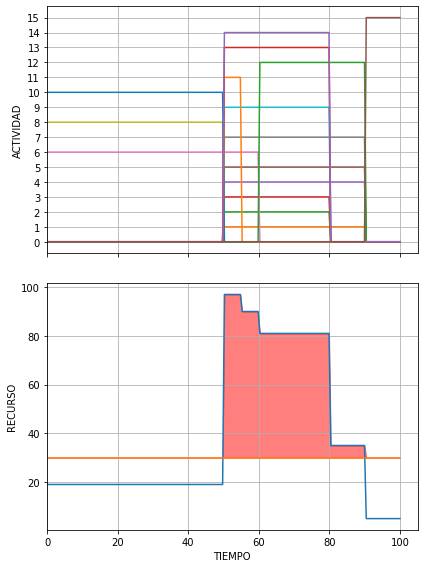

50 55
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 10, 7, 4, 4]


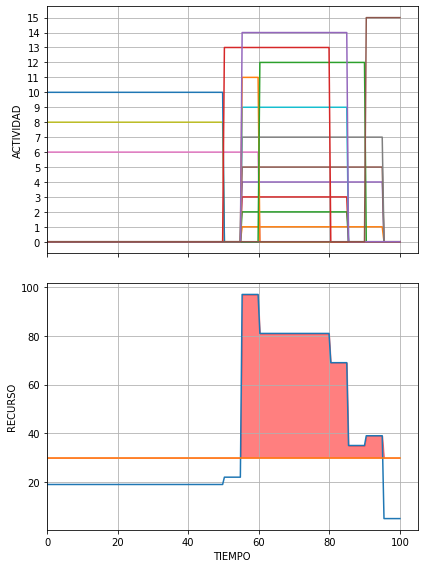

55 60
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 10, 7, 4, 4]


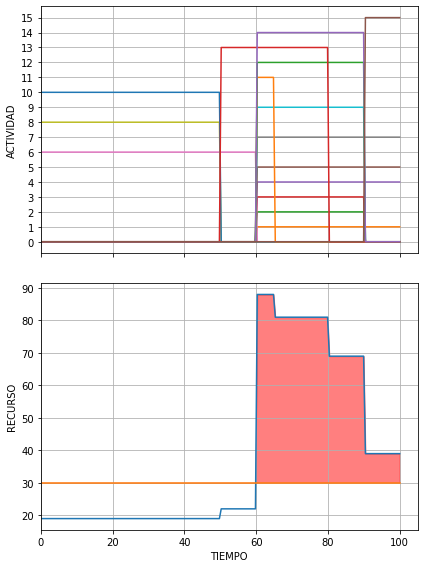

60 65
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 7, 1, 4, 4]


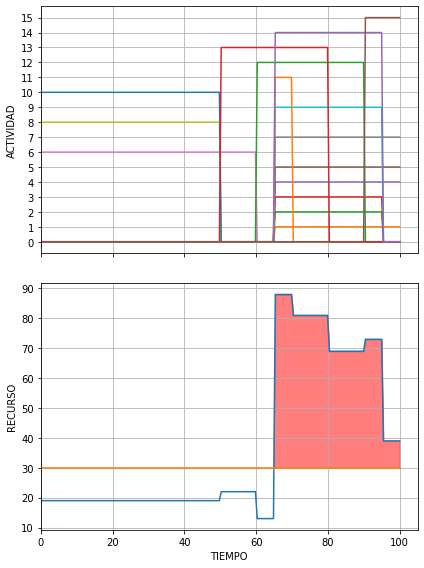

65 70
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 7, 1, 4, 4]


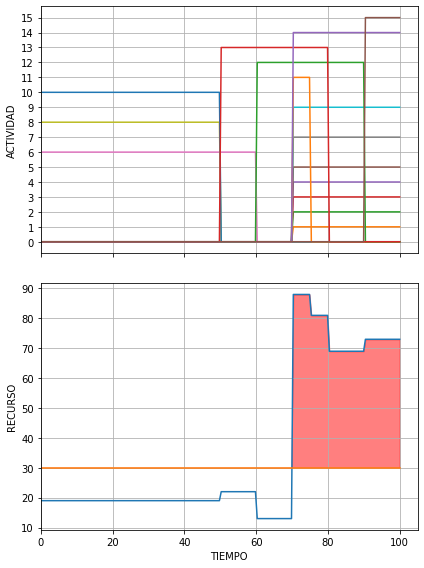

70 75
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 7, 1, 4, 4]


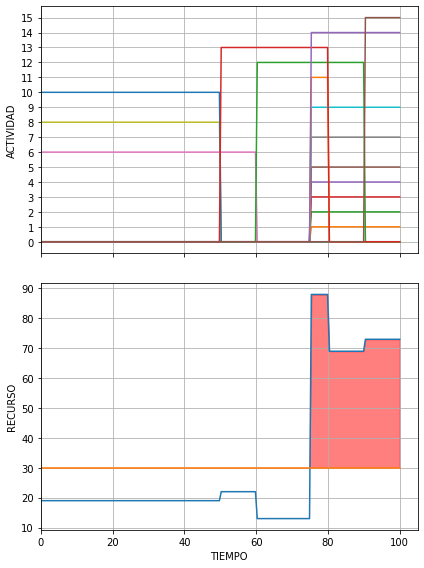

75 80
[0.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 12, 10, 10, 10, 10, 7, 1, 4, 4]


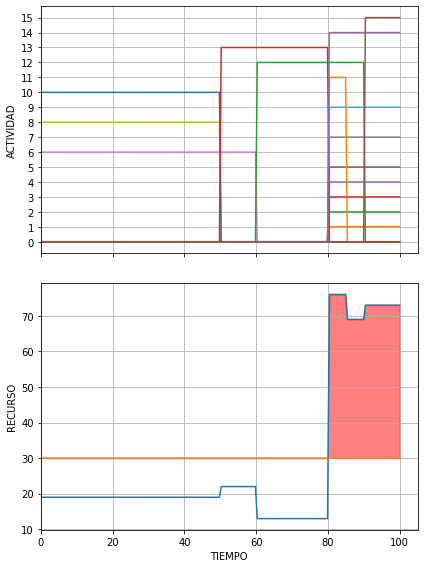

80 85
[0.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 4, 10, 7, 1, 4]


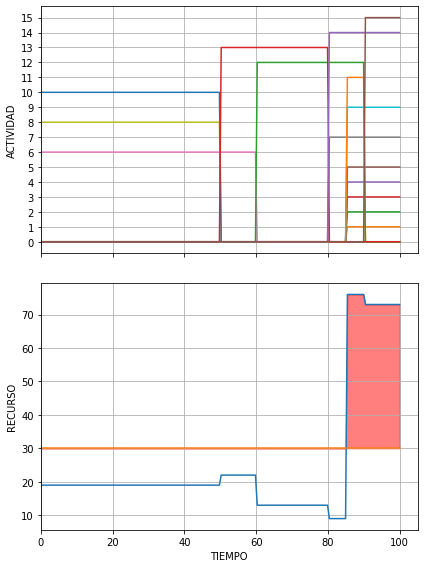

85 90
[0.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 4, 10, 7, 1, 4]


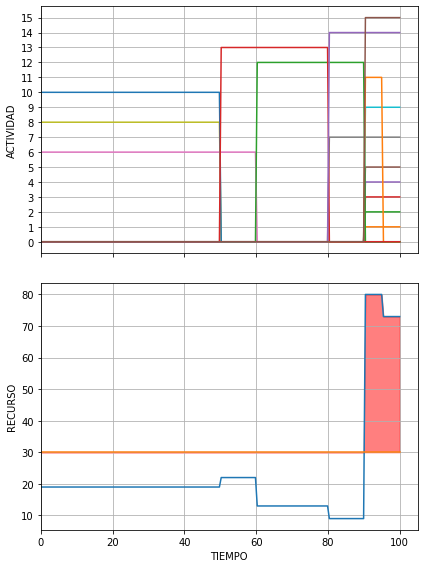

90 95
[0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 5, 10, 7, 4, 4]


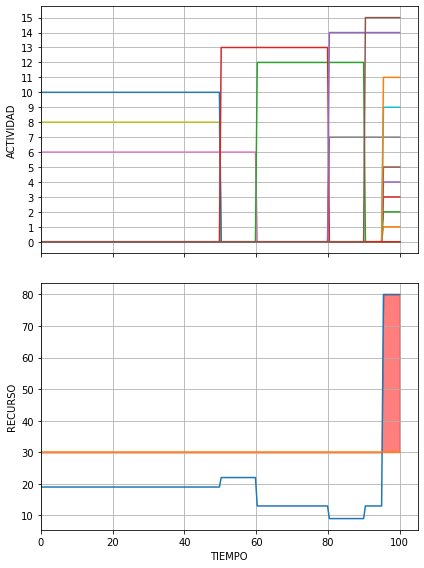

95 100
[0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 50.0, 85.0]
[10, 10, 10, 10, 10, 5, 10, 7, 4, 4]


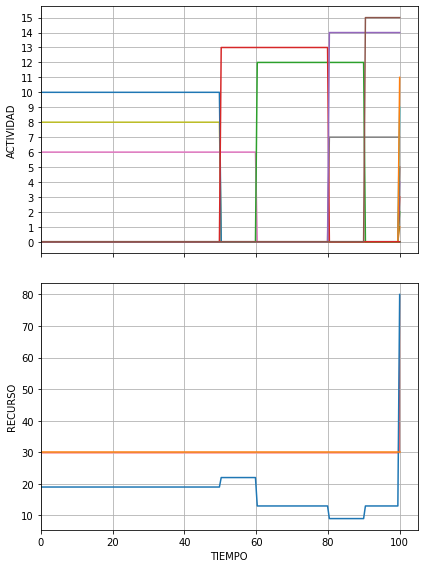

UnboundLocalError: ignored

In [57]:
s.gray_kidd(df["recurso"],30)